In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
# upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mini1102","key":"2a24ff673dc493fc4f88e61b71cb635c"}'}

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification'

# Download the dataset using opendatasets
od.download(dataset_url)


Skipping, found downloaded files in "./fresh-and-stale-classification" (use force=True to force download)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
!pip install torchmetrics
import torchmetrics
from torchmetrics import Metric
import torchvision
from torchvision import models
import cv2 as op

plt.style.use('seaborn')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 16.8 MB/s eta 0:00:00


('1.26.4', 'cpu')

In [ ]:
TRAIN_PATH = '/content/fresh-and-stale-classification/dataset/Train/'
TEST_PATH = '/content/fresh-and-stale-classification/dataset/Test/'

def load_data(PATH):
    filenames, fruit, fresh = [], [], []

    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6: ])
            filenames.append(os.path.join(PATH, file, img))

    df = pd.DataFrame({
        'filename' : filenames,
        'fruit' : fruit,
        'fresh' : fresh
    })

    return df

df_train = load_data(TRAIN_PATH).sample(frac = 1)
df_test = load_data(TEST_PATH).sample(frac = 1)

df_train.shape, df_test.shape


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

((23619, 3), (6738, 3))

In [ ]:
df_train.drop(df_train[(df_train['fruit'] == 'capsicum') & (df_train['fruit'] == 'bittergourd')].index, inplace = True)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'tomato' if x == 'tamto' else x)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'potato' if x == 'patato' else x)

In [ ]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(30357, 3)

<Axes: xlabel='fruit', ylabel='count'>

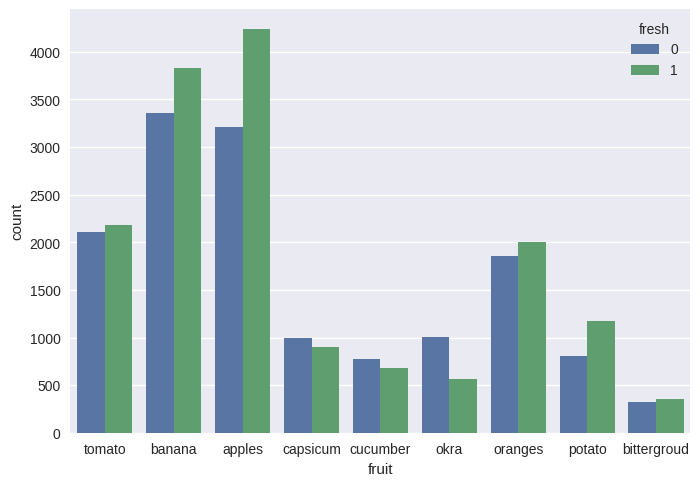

In [ ]:
sea.countplot(x = 'fruit', data = df, hue = 'fresh')

In [ ]:
counts = df['fruit'].value_counts()
df_new = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])

for (key, value) in counts.items():
    if value > 1500:
        df_temp = df[df['fruit'] == key].sample(n = 1500)
    else:
        df_temp = df[df['fruit'] == key]

    df_new = pd.concat([df_new, df_temp], axis = 0)

df_new.shape

(12635, 3)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_new['fruit_label'] = le.fit_transform(df_new['fruit'])
df_new.shape

(12635, 4)

In [ ]:
df_new.head()

,filename,fruit,fresh,fruit_label
2353,/content/fresh-and-stale-classification/datase...,apples,1,0
316,/content/fresh-and-stale-classification/datase...,apples,1,0
16516,/content/fresh-and-stale-classification/datase...,apples,0,0
741,/content/fresh-and-stale-classification/datase...,apples,1,0
16442,/content/fresh-and-stale-classification/datase...,apples,0,0


<Axes: xlabel='fruit', ylabel='count'>

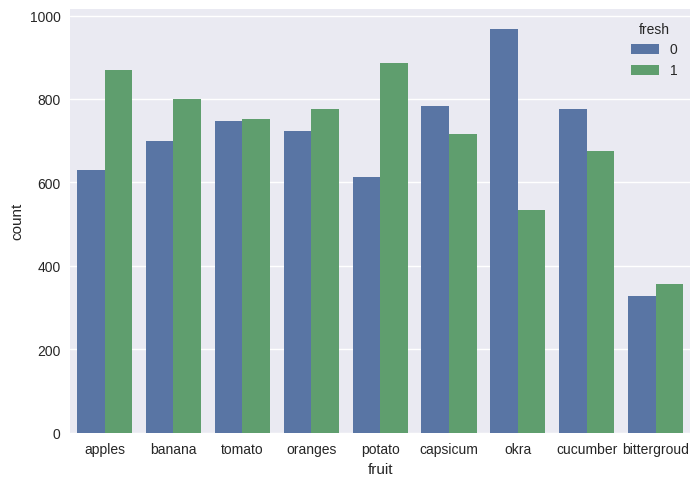

In [ ]:
sea.countplot(x = 'fruit', data = df_new, hue = 'fresh')

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_new, test_size = 0.15, stratify = df_new['fruit_label'])

df_train.shape, df_val.shape

((10739, 4), (1896, 4))

<Axes: xlabel='fruit_label', ylabel='count'>

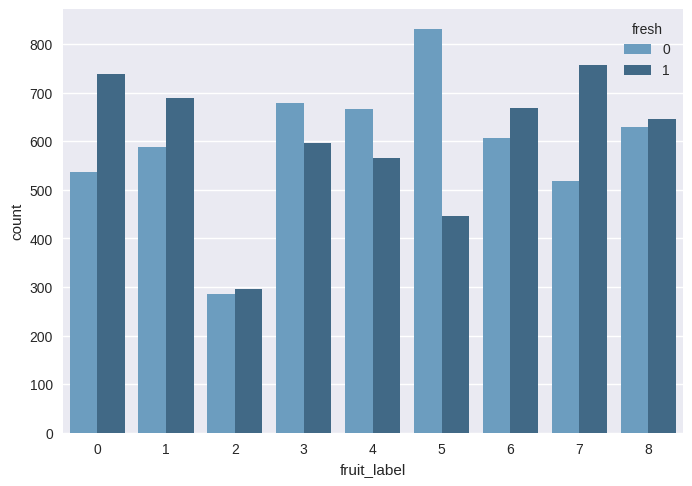

In [ ]:
sea.countplot(x = 'fruit_label', data = df_train, hue = 'fresh', palette = 'Blues_d')

<Axes: xlabel='fruit', ylabel='count'>

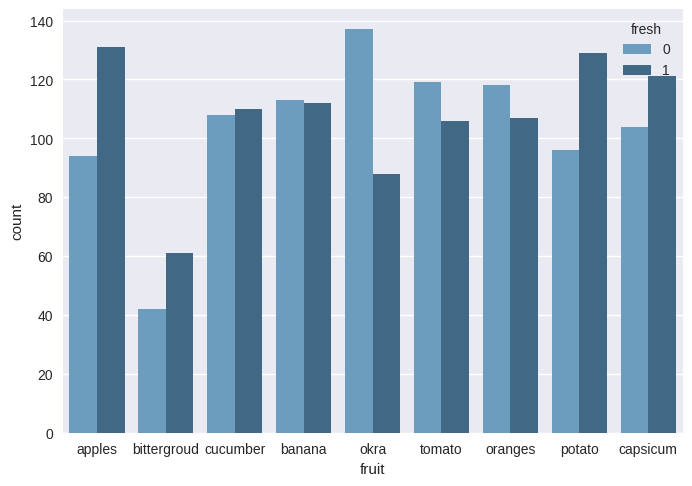

In [ ]:
sea.countplot(x = 'fruit', data = df_val, hue = 'fresh', palette = 'Blues_d')

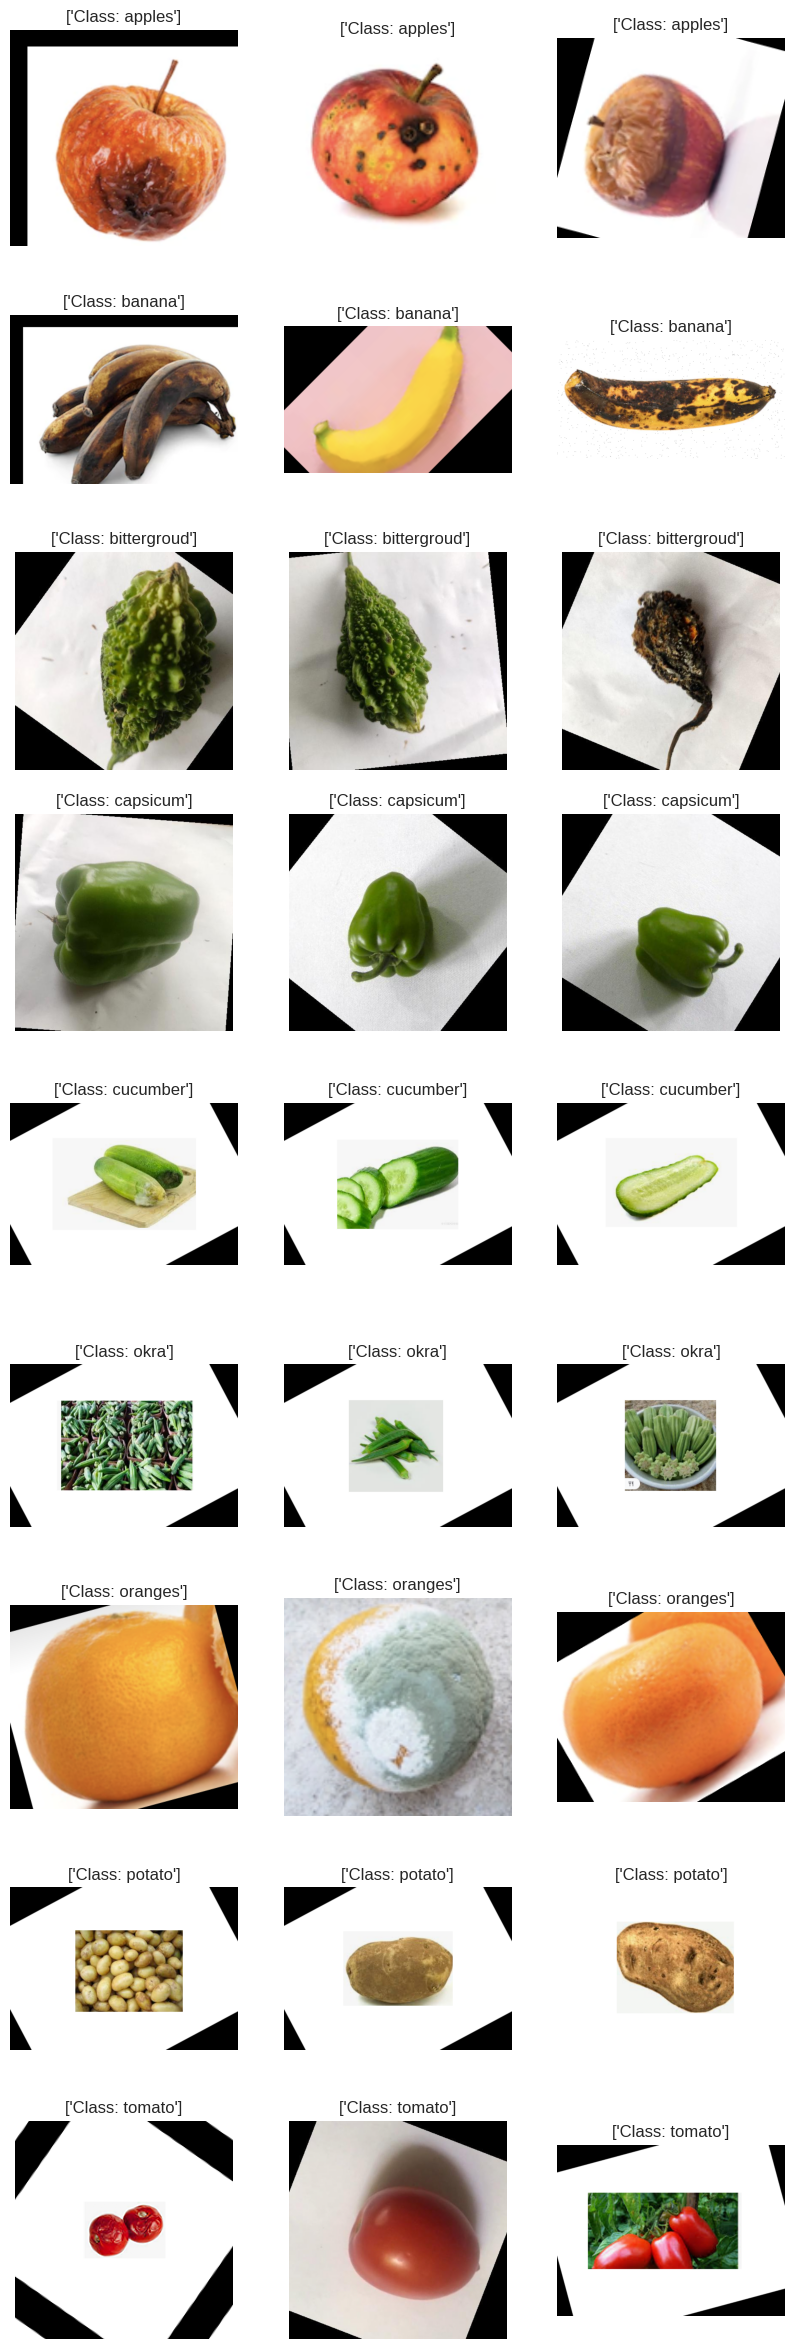

In [ ]:
def load_image(path):
    img = plt.imread(path)
    return img

counter = 0

plt.figure(figsize = (10, 30))

for i in range(9):
    for path in df_train[df_train['fruit_label'] == i].sample(n = 3)['filename']:
        plt.subplot(9, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + le.inverse_transform([i]))
        counter += 1

plt.show()

In [ ]:

def image_transform(img, p = 0.5, training = True):
    if training:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = p),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomAdjustSharpness(3, p = p),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)
    else:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)

    return img

class FruitDataset:
    def __init__(self, df, training):
        self.df = df
        self.n_samples = len(self.df)
        self.training = training

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
        fresh = torch.tensor(self.df.iloc[idx][2])
        fruit = torch.tensor(self.df.iloc[idx][3])

        img = image_transform(img, p = 0.5, training = self.training)

        return img, fruit, fresh


In [ ]:
BATCH_SIZE = 64


train_dataset = FruitDataset(df_train, training = True)
val_dataset = FruitDataset(df_val, training = False)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)


In [ ]:
a, b, c = next(iter(train_loader))
print(a.shape, b.shape, c.shape)
del(a)
del(b)
del(c)

torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64])


In [ ]:
import math

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = 0.7

        self.base = torchvision.models.resnet18(pretrained = True)

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()

        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
        )

        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 9)
        )

        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)
        )

        self.optimizer1 = torch.optim.Adam([
            {'params' : self.base.parameters(), 'lr': 1e-5},
            {'params' : self.block1.parameters(),  'lr': 3e-4}
        ])

        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr = 3e-4)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr = 3e-4)

        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes = 9)
        self.fresh_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 2)

        self.TRAIN_BATCHES = math.ceil(len(train_dataset)/BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset)/BATCH_SIZE)

        self.history = {'train_loss': [], 'val_loss': [],
                    'train_acc_fruit': [], 'train_acc_fresh': [],
                    'val_acc_fruit': [], 'val_acc_fresh': []}


    def forward(self, x):
        x = self.base(x)
        x = self.block1(x)
        y1, y2 = self.block2(x), self.block3(x)

        return y1, y2


    def train_step(self, x, y1, y2):
        pred1, pred2 = self.forward(x)
        l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)

        # Combine losses before backward pass
        loss = self.alpha * l1 + (1 - self.alpha) * l2

        # Zero gradients for all optimizers
        self.optimizer1.zero_grad()
        self.optimizer2.zero_grad()
        self.optimizer3.zero_grad()

        # Perform a single backward pass
        loss.backward()

        # Update all optimizers
        self.optimizer1.step()
        self.optimizer2.step()
        self.optimizer3.step()

        fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
        fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)

        return loss, fruit_acc, fresh_acc


    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
            return loss, fruit_acc, fresh_acc

    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)


    def train(self, epochs = 5):

        for epoch in tqdm(range(epochs)):

            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0

            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()

            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()

            train_loss, train_fruit, train_fresh = [x/self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x/self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]

            self.update_history( train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)

            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(epoch, train_loss, train_fruit, train_fresh,
                                                                                                                                          val_loss, val_fruit, val_fresh))


In [ ]:
model = Model().to(device)

In [ ]:
model.train(epochs=6)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch: 0] Train: [loss: 0.594, fruit: 0.801 fresh: 0.795] Val: [loss: 0.171, fruit: 0.951 fresh: 0.908]


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.134, fruit: 0.965 fresh: 0.923] Val: [loss: 0.109, fruit: 0.973 fresh: 0.944]


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.093, fruit: 0.977 fresh: 0.942] Val: [loss: 0.085, fruit: 0.981 fresh: 0.944]


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.067, fruit: 0.984 fresh: 0.957] Val: [loss: 0.065, fruit: 0.987 fresh: 0.959]


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.050, fruit: 0.992 fresh: 0.964] Val: [loss: 0.064, fruit: 0.988 fresh: 0.960]


  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.042, fruit: 0.991 fresh: 0.971] Val: [loss: 0.054, fruit: 0.989 fresh: 0.964]


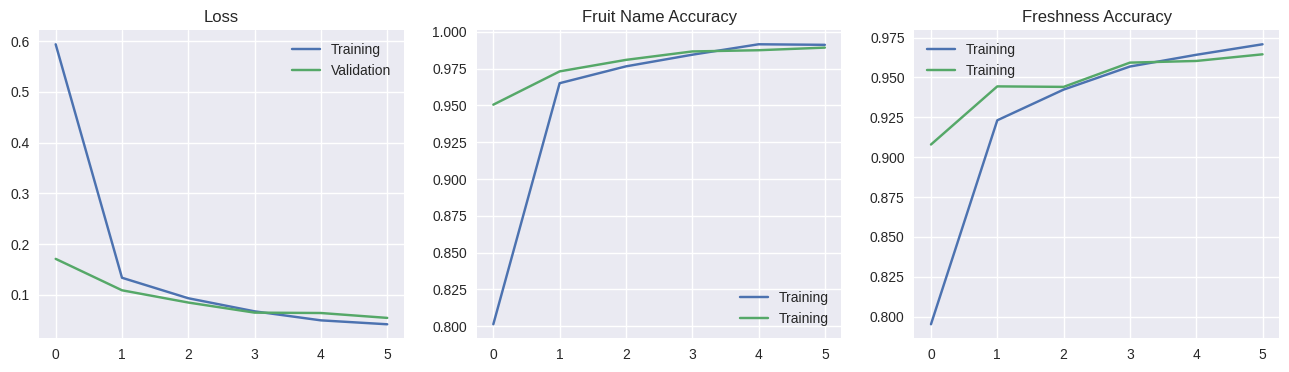

In [ ]:
plt.figure(figsize = (16, 4))

plt.subplot(1,3,1)
plt.title('Loss')
plt.plot(model.history['train_loss'], label = 'Training')
plt.plot(model.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,3,2)
plt.title('Fruit Name Accuracy')
plt.plot(model.history['train_acc_fruit'], label = 'Training')
plt.plot(model.history['val_acc_fruit'], label = 'Training')
plt.legend()

plt.subplot(1,3,3)
plt.title('Freshness Accuracy')
plt.plot(model.history['train_acc_fresh'], label = 'Training')
plt.plot(model.history['val_acc_fresh'], label = 'Training')
plt.legend()


In [ ]:
preds1, preds2, fruit, fresh = [], [], [], []

with torch.no_grad():
    for x, y1, y2 in tqdm(val_loader):
        pred = model(x.to(device))

        pred1 = torch.argmax(pred[0], axis = 1).detach().cpu().numpy()
        pred2 = torch.argmax(pred[1], axis = 1).detach().cpu().numpy()
        preds1.extend(pred1)
        preds2.extend(pred2)
        fruit.extend(y1)
        fresh.extend(y2)


len(fruit), len(fresh), len(preds1), len(preds2)

  0%|          | 0/30 [00:00<?, ?it/s]

(1896, 1896, 1896, 1896)

Text(0.5, 1.0, 'Confusion Matrix for Fruit Names')

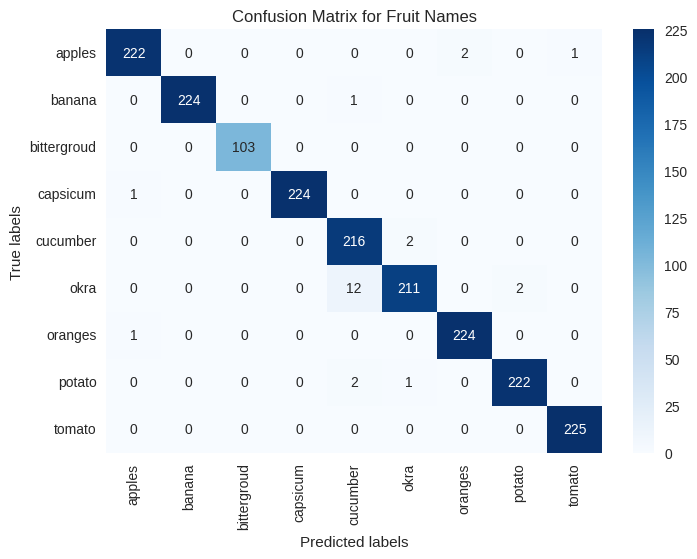

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = le.inverse_transform(np.arange(0, 9))

cm = confusion_matrix(fruit, preds1)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = class_names, yticklabels = class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fruit Names')

Text(0.5, 1.0, 'Confusion Matrix for Freshness')

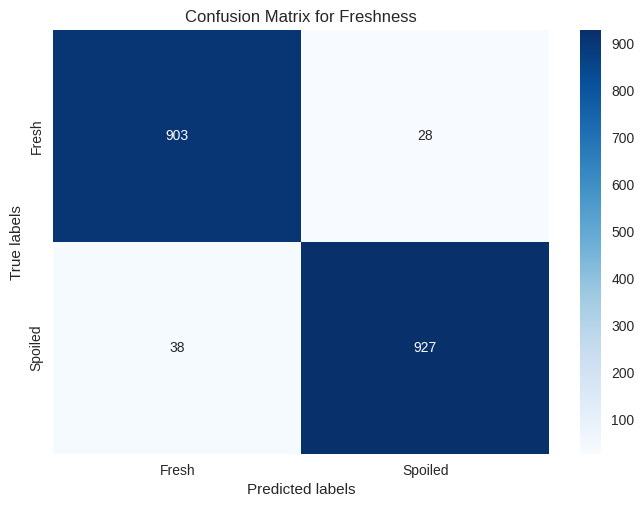

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(fresh, preds2)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = ['Fresh', 'Spoiled'], yticklabels = ['Fresh', 'Spoiled'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Freshness')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(fruit, preds1, target_names = class_names))
print(classification_report(fresh, preds2, target_names = ['Fresh', 'Spoiled']))

              precision    recall  f1-score   support

      apples       0.99      0.99      0.99       225
      banana       1.00      1.00      1.00       225
 bittergroud       1.00      1.00      1.00       103
    capsicum       1.00      1.00      1.00       225
    cucumber       0.94      0.99      0.96       218
        okra       0.99      0.94      0.96       225
     oranges       0.99      1.00      0.99       225
      potato       0.99      0.99      0.99       225
      tomato       1.00      1.00      1.00       225

    accuracy                           0.99      1896
   macro avg       0.99      0.99      0.99      1896
weighted avg       0.99      0.99      0.99      1896

              precision    recall  f1-score   support

       Fresh       0.96      0.97      0.96       931
     Spoiled       0.97      0.96      0.97       965

    accuracy                           0.97      1896
   macro avg       0.97      0.97      0.97      1896
weighted avg       0.97